# MobileNet

## Questions:
- **What are the advantages and tradeoffs of the MobileNet family of CNNs?**
    - MobileNet family of CNNs are models with significantly fewer parameters and smaller disk space when compared with other models such VGG16. MobileNet models requires smaller hardware requirements during training, using GPU is not optional. The tradeoff would be its accuracy. Since they have fewer parameters, the model may show results with  a reduced accuracy due to its limited weights. 

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(f"Num GPUs Available: {len(physical_devices)}")

Num GPUs Available: 1


In [38]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [39]:
def prepare_image(file):
    img_path = "/kaggle/input/sign-language-digits/Sign-Language-Digits-Dataset/"
    img = image.load(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [40]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Image Preparation
Dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset

- 10 classes (0-9)
- Class Data:
    - class 0: 205 images
    - class 1: 206 images
    - class 2: 206 images
    - class 3: 206 images
    - class 4: 207 images
    - class 5: 207 images
    - class 6: 207 images
    - class 7: 206 images
    - class 8: 208 images
    - class 9: 204 images

In [42]:
"""
The following code was run on a local jupyter notebook 
since it is difficult to files in Kaggle directories.
"""

# # Organize data into train, valid, test dirs

# os.chdir("data/Sign-Language-Digits-Dataset")
# if os.path.isdir("train/0/") is False:
#     os.mkdir("train")
#     os.mkdir("valid")
#     os.mkdir("test")

#     for i in range(0, 10):
#         shutil.move(f"{i}", "train")
#         os.mkdir(f"valid/{i}")
#         os.mkdir(f"test/{i}")

#         valid_samples = random.sample(os.listdir(f"train/{i}"), 30)
#         for filename in valid_samples:
#             shutil.move(f"train/{i}/{filename}", f"valid/{i}")
        
#         test_samples = random.sample(os.listdir(f"train/{i}"), 5)
#         for filename in test_samples:
#             shutil.move(f"train/{i}/{filename}", f"test/{i}")

# os.chdir("./../../")

'\nThe following code was run on a local jupyter notebook \nsince it is difficult to files in Kaggle directories.\n'

In [43]:
for i in range(0, 10):
    assert len(os.listdir(f"/kaggle/input/sign-language-digits-dataset/valid/{i}")) == 30
    assert len(os.listdir(f"/kaggle/input/sign-language-digits-dataset/test/{i}")) == 5

In [44]:
train_path = "/kaggle/input/sign-language-digits-dataset/train"
valid_path = "/kaggle/input/sign-language-digits-dataset/valid"
test_path = "/kaggle/input/sign-language-digits-dataset/test"

In [45]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=32)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [46]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

## Modify Model

In [47]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [48]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [49]:
params = count_params(mobile)
assert params["non_trainable_params"] == 21_888
assert params["trainable_params"] == 4_231_976

In [50]:
# x = mobile.layers[-5].output
# x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
# output = Dense(units=10, activation="softmax")(x)

x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=10, activation='softmax')(x)

In [51]:
model = Model(inputs=mobile.input, outputs=output)

In [52]:
for layer in model.layers[:-23]:
    layer.trainable = False
    

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [54]:
# # Ignore parameter count check since update in tensorflow changed included a new default parameter
# params = count_params(model)
# assert params["non_trainable_params"] == 1_365_184
# assert params["trainable_params"] == 1_873_930

## Train the Model

In [55]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [56]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
54/54 - 11s - loss: 0.8142 - accuracy: 0.7593 - val_loss: 1.5120 - val_accuracy: 0.4967 - 11s/epoch - 211ms/step
Epoch 2/30
54/54 - 4s - loss: 0.1325 - accuracy: 0.9866 - val_loss: 0.4572 - val_accuracy: 0.8700 - 4s/epoch - 80ms/step
Epoch 3/30
54/54 - 4s - loss: 0.0672 - accuracy: 0.9971 - val_loss: 0.1846 - val_accuracy: 0.9767 - 4s/epoch - 81ms/step
Epoch 4/30
54/54 - 4s - loss: 0.0394 - accuracy: 0.9982 - val_loss: 0.1160 - val_accuracy: 0.9833 - 4s/epoch - 74ms/step
Epoch 5/30
54/54 - 4s - loss: 0.0250 - accuracy: 0.9988 - val_loss: 0.0911 - val_accuracy: 0.9900 - 4s/epoch - 74ms/step
Epoch 6/30
54/54 - 4s - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.9900 - 4s/epoch - 77ms/step
Epoch 7/30
54/54 - 4s - loss: 0.0154 - accuracy: 0.9994 - val_loss: 0.0733 - val_accuracy: 0.9900 - 4s/epoch - 74ms/step
Epoch 8/30
54/54 - 4s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0677 - val_accuracy: 0.9900 - 4s/epoch - 80ms/step
Epoch 9/30
54/54 - 4s - loss:

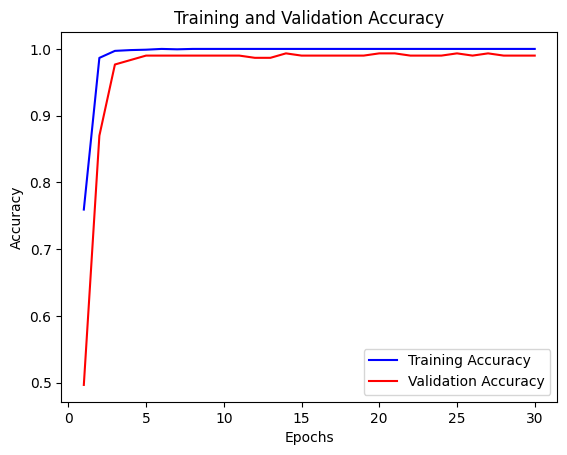

In [57]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)
# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b',label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

## Predict sign language digits

In [58]:
test_labels = test_batches.classes

In [59]:
predictions = model.predict(x=test_batches, verbose=0)

In [60]:
# cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=-1))
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))

In [61]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[1 1 0 0 1 1 0 0 0 1]
 [0 1 0 1 0 0 1 0 1 1]
 [1 0 1 0 0 1 0 0 2 0]
 [0 0 2 0 0 2 0 1 0 0]
 [0 0 0 2 1 0 1 0 0 1]
 [0 0 2 0 1 0 1 0 0 1]
 [1 1 0 0 1 0 1 0 1 0]
 [0 1 0 0 0 1 1 1 0 1]
 [0 1 0 2 0 0 0 1 1 0]
 [2 0 0 0 1 0 0 2 0 0]]


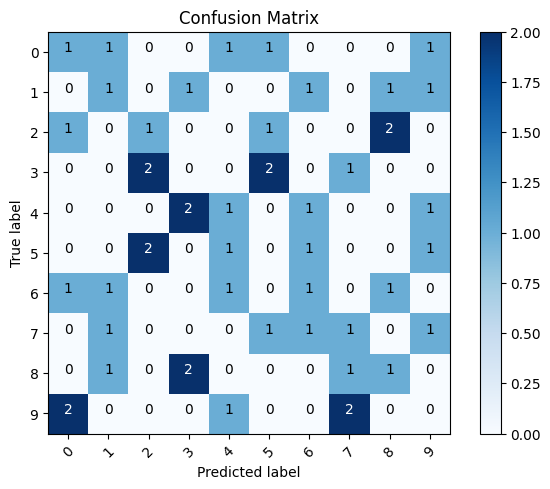

In [62]:
cm_plot_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [63]:
# Given code snippet, there seems to be an error, iter not exhausting
# test_accuracy_values = []
# while True:
#     try:
#         test_data_batch, test_labels_batch = next(test_batches)
#         test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
#         test_accuracy_values.append(test_accuracy)
#     except StopIteration:
#         break # Break the loop when you've processed all batches

# # Calculate the overall test accuracy
# overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
# print("Overall Test Accuracy:", overall_test_accuracy)
   

test_accuracy_values = []
while len(test_accuracy_values) < test_batches.n:
    test_data_batch, test_labels_batch = next(test_batches)
    test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
    test_accuracy_values.append(test_accuracy)
    
# Calculate the overall test accuracy
overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
print("Overall Test Accuracy:", overall_test_accuracy)   

1/1 [==============================] - 0s 40ms/step - loss: 0.0115 - accuracy: 1.0000
Overall Test Accuracy: 1.0


## Save model

In [66]:
model.save("models/sign-language-digits.h5")